# Лабораторная работа 1

Не забываем загрузить библиотеки:

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Библиотека для работы с матрицами
import numpy as np 

# Алгоритмы линейной алгебры
import scipy.linalg as sla

# Библиотека для работы с разреженными матрицами
import scipy.sparse as sps

# Алгоритмы линейной алгебры для разреженных матриц
import scipy.sparse.linalg as spla

# Графическая библиотека
import matplotlib.pyplot as plt

# Позволяет отрисовывать графики и изображения прямо в ноутбуке, а не в отдельном окне. Жизненно важная вещь!
%matplotlib inline

## Часть 1. Особенности LU-разложения

С точки зрения математики матричные разложения являются точными: произведение сомножителей всегда равняется исходной матрицы $A$. К сожалению, на практике этом часто мешает вычислительная погрешность. 

Для $LU$ разложения l2-норма ошибки ошибки $||\delta A|| = ||A - LU||$ удовлетворяет следующей оценке:

$$||\delta A|| \leqslant ||L|| \cdot ||U|| \cdot O(\varepsilon_{machine})$$

А нормы $L$ и $U$ могут быть совсем нехорошими.

**Задание 1.1 (1 балл)** Рассмотрим следующее LU-разложение:

$$\begin{pmatrix}
10^{-20} & 1\\
1 & 1
\end{pmatrix} = \begin{pmatrix}
1 & 0\\
10^{20} & 1
\end{pmatrix}\cdot\begin{pmatrix}
10^{-20} & 1\\
0 & 1 - 10^{20}
\end{pmatrix}$$

Перемножьте полученные матрицы $L$ и $U$. А теперь перемножьте такие же матрицы, только после всех единиц поставьте десятичные точки. Изменился ли ответ? Как вам кажется, почему?

In [5]:
L = np.array([[1, 0], [10**20, 1]])
U = np.array([[10**-20, 1], [0, 1 - 10**20]])

print(type(U[1][1]))

print("L:\n", L)
print("U:\n", U)
LU = np.dot(L, U)
print("L*U: \n", LU)

<class 'int'>
L:
 [[1 0]
 [100000000000000000000 1]]
U:
 [[1e-20 1]
 [0 -99999999999999999999]]
L*U: 
 [[1e-20 1]
 [1.0 1]]


In [6]:
L = np.array([[1.00, 0.0], [10**20, 1.0]])
U = np.array([[10**-20, 1], [0, 1.0 - 10**20]])

print(type(U[1][1]))

print("L:\n", L)
print("U:\n", U)
LU = np.dot(L, U)
print("L*U: \n", LU)

<class 'numpy.float64'>
L:
 [[1.0 0.0]
 [100000000000000000000 1.0]]
U:
 [[ 1.e-20  1.e+00]
 [ 0.e+00 -1.e+20]]
L*U: 
 [[1e-20 1.0]
 [1.0 0.0]]


**Ответ изменился. В первом случае элемент в матрице U (1,1) равен действительно 1 - $10^{20}$, а во втором случае единица поглотилась числом $10^{20}$. Причина в том, что в первом случае элемент U(1,1) имеет тип int, а int точно может представляться в компьютерной арифметике. А во втором случае, элемент U(1,1) имеет вещественный тип, который не всюду представим, чем больше значение, тем меньше он представляет чисел.**

Отметим, что в реальных вычислениях матричные элементы почти наверняка с самого начала будут числами с плавающей точкой (а не целыми).

Теперь проверьте, что будет, если вычислить QR-разложение исходной матрицы и перемножить матрицы $Q$ и $R$.

In [7]:
A = np.array([[1e-20, 1], [1, 1]], dtype=np.float64)

Q,R = sla.qr(A)
print("Q:\n", Q)
print("R:\n", R)
QR = np.matmul(Q, R)
print("Q*R:\n", QR)

Q:
 [[ 0. -1.]
 [-1.  0.]]
R:
 [[-1. -1.]
 [ 0. -1.]]
Q*R:
 [[0. 1.]
 [1. 1.]]


**Тут снова ошибка, но в этот раз в элементе Q(0,0). Логично предположить что при разложении элемент $10^{-20}$ вышел из представления и превартился в нуль.**

**Выход: LU-разложение с выбором главного элемента (по столбцу)**

Каждый раз ищем максимум в столбце и переставляем соответствующую строку наверх.

$$\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow
\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow$$
$$\longrightarrow\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & 0 & b'_{i+1,i+1} & \dots & b'_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & 0 & b'_{i,i+1} & \dots & b'_{in} \\
 & & \vdots & \vdots & & \vdots
\end{pmatrix}$$

Надо сказать, что примерно так вы все и решали системы на первом курсе университета! Именно наибольший, а не первый ненулевой элемент столбца берётся потому, что чем больше число - тем меньшие погрешности потенциально вносит деление на него.

Что при этом происходит? Перестановка строк матрицы равносильна умножению её слева на матрицу соответствующей перестановки. Таким образом, мы получаем равенство

$$L_nP_nL_{n-1}P_{n-1}\ldots L_2P_2L_1P_1 A = U\qquad\qquad(1)$$

где $L_1,\ldots,L_n$ - некоторые нижнетреугольные матрицы.

**Вопрос:** Ну, и где здесь матрица $L$?!

**Ответ:** Введём новые матрицы

\begin{align*}
L'_n &= L_n\\
L'_{n-1} &= P_nL_nP_{n-1}\\
L'_{n-2} &= P_nP_{n-1}L_{n-1}P_n^{-1}P_{n-1}^{-1}\\
&\ldots\\
L'_1 &= P_nP_{n-1}\ldots P_2L_1P_2^{-1}\ldots P_{n-1}^{-1}P_n^{-1}
\end{align*}

**Упражнение.** Матрицы $L'_i$ тоже нижнетреугольные!

Тогда левая часть (1) перепишется в виде

$$\underbrace{L'_nL'_{n-1}\ldots L'_1}_{:=L^{-1}}\underbrace{P_nP_{n-1}\ldots P_1}_{:=P^{-1}}\cdot A$$

**Итог:** разложение вида
$$A = PLU$$
где $P$ - матрица перестановки.

Функция `scipy.linalg.lu` в Питоне находит именно такое разложение!

Все элементы $L$ не превосходят $1$, так что $||L||]\leqslant 1$. При этом
$$||\Delta A|| \leqslant ||A||\cdot O(\rho \varepsilon_{machine}),$$
где
$$\rho = \frac{\max_{i,j}|u_{ij}|}{\max_{i,j}|a_{ij}|}$$
Это число называется *фактором роста матрицы*.

Но что, если это отношение велико?

**Задание 1.2 (1 балл)** Сгенерируйте матрицу $500\times500$, имеющую вид

$$\begin{pmatrix}
1 & 0 & 0 & \cdots & 0 & 0 & 1\\
-1 & 1 & 0 &  &  & 0 & 1\\
-1 & -1 & 1 & 0  &  & 0 & 1\\
\vdots & & \ddots & \ddots  & \ddots & \vdots & \vdots \\
-1 & -1 & -1 & \ddots & 1 & 0 & 1\\
-1 & -1 & -1 &  & -1 & 1 & 1\\
-1 & -1 & -1 & \cdots & -1 & -1 & 1
\end{pmatrix}$$

Например, сгенерировать сначала нулевую матрицу нужного размера, а потом заполнить её клетки правильными числами.

Найдите её PLU-разложение и QR-разложение. Убедитесь, что $P = E$. Вычислите $||A - LU||_2$ и $||A - QR||_2$. Чему равен фактор роста матрицы $A$? Сделайте вывод об устойчивости (или не устойчивости) нахождения PLU-разложения.

In [8]:
def sign(i, j):
    if (j < i):
        return -1
    elif i == j or j == 499:
        return 1
    return 0

A = np.array([[sign(i,j) for j in range(500)] for i in range(500)])
print(A)

[[ 1  0  0 ...  0  0  1]
 [-1  1  0 ...  0  0  1]
 [-1 -1  1 ...  0  0  1]
 ...
 [-1 -1 -1 ...  1  0  1]
 [-1 -1 -1 ... -1  1  1]
 [-1 -1 -1 ... -1 -1  1]]


In [9]:
E = np.identity(500)
P,L,U = sla.lu(A)
print(np.mean(P == E))

1.0


In [10]:
Q,R = sla.qr(A)

In [11]:
norm_lu = sla.norm(A - np.matmul(L, U))
print('LUP norm ', norm_lu)

norm_qr = sla.norm(A - np.matmul(Q, R))
print('QR norm ',norm_qr)

LUP norm  5.0768322940305e+114
QR norm  8.799770347058781e-13


In [12]:
p = sla.norm(U, ord=np.inf)/sla.norm(A, ord=np.inf)
print('factor p ', p)

factor p  3.273390607896142e+147


**Так как $\| A - L U \| _ { 2 }$ очень большое число, значит PLU разложение не устойчивое. Это подтверждается значением фактора роста.**

К счастью, на практике так редко бывает (чёрт его знает почему). Тем не менее, QR-разложение всё-таки лучше. Теоретическая оценка для ошибки QR-разложения имеет вид

$$||A - QR||_2 \leqslant ||A||_2\cdot O(\varepsilon_{machine})$$

**Задание 1.3 (1 балл)** Рассмотрим *матрицу Паскаля* $S_n = \left(C_{i + j}^i\right)$ ($i,j = 0,\ldots,n-1$).

Каково её LU-разложение? Выведите формулы для матриц L и U и приведите краткое обоснование прямо в ноутбуке. Не пользуйтесь функцией `scipy.linalg.lu`, чтобы его "угадать": матрица P будет отлична от единичной, и вы получите не то, что хотели.

Каков её определитель? Обязательно обоснуйте ответ.

**Если воспользоваться методом гаусса, то можно легко увидеть, что нижнетреуголльная матрица $L = \left(C_{i}^j\right)$, а верхнетреугольная матрица $U = \left(C_{j}^i\right)$.**


**Определитель матриц L,U, A равен единице так как, на диагонали матриц L,U стоят всегда 1 <= $\left(C_{i}^i\right)=1$, ну а поскольку в треугольной матрице определитель равен произведению диагонали, тогда и сам определитель равен 1. Ну и следовательно $det(A)=det(L)\cdot  det(U) => det(A) = 1$**


Напишите функцию `my_pascal(n)`, генерирующую матрицу Паскаля размера $n\times n$.

In [13]:
import scipy.special as scs
def my_pascal(n):
    return np.array([[scs.comb(i + j, i) for j in range(n)] for i in range(n)])


def l_pascal(n):
    return np.array([[scs.comb(i, j) if j <= i else 0 for j in range(n)] for i in range(n)])

def u_pascal(n):
    return np.array([[scs.comb(j, i) if j >= i else 0 for j in range(n)] for i in range(n)])

A = my_pascal(3)
L = l_pascal(3)
U = u_pascal(3)
LU = np.matmul(L, U)
print("Pascal Matrix\n", A)
print("L\n", L)
print("U\n", U)
print("LU\n", LU)
print(A==LU)

Pascal Matrix
 [[1. 1. 1.]
 [1. 2. 3.]
 [1. 3. 6.]]
L
 [[1. 0. 0.]
 [1. 1. 0.]
 [1. 2. 1.]]
U
 [[1. 1. 1.]
 [0. 1. 2.]
 [0. 0. 1.]]
LU
 [[1. 1. 1.]
 [1. 2. 3.]
 [1. 3. 6.]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [14]:
print(sla.det(A))
print(sla.det(L))
print(sla.det(U))

1.0
1.0
1.0


**Что и следовало ожидать**

Найдите норму разности $||A - PLU||_2$. Не такая уж и большая, правда?

In [15]:
A = my_pascal(30)
L = l_pascal(30)
U = u_pascal(30)

norm = sla.norm(A - np.matmul(L, U))
print(norm)

16.863232991023153


Теперь попросим компьютер вычислить определитель матрицы Паскаля $30\times30$ и решить простенькую систему уравнений:

In [16]:
print(sla.det(A))

# Try to solve a linear system
x = np.ones(30)
b = A.dot(x)
x1 = sla.solve(A, b)
print(sla.norm(x1 - x))

1.178037022515363e+49
24552891.1281253


Так себе ошибка. Теперь попробуем сделать это с помощью QR-разложения. Станет ли лучше?

In [17]:
Q, R = sla.qr(A)
x2 = sla.solve_triangular(R, Q.T.dot(b))
print(sla.norm(x2 - x))

644500689.5667214


Объясните полученные неприятные результаты.

**При решении системы, используется метод Гаусса. На каждой итерации необходимо вычитать одну строку из других строк. Учитывая что проводятся операции с очень большими числами, например: **

In [18]:
scs.comb(29+29, 29)

3.0067266499541044e+16

**То будут появляться ошибки округления, которые в итоге накапливаются и приводят к серьезныи ошибкам при решении.**

## Часть 2. Решение СЛАУ с положительно определённой матрицей

**Задание 2.1. Какие же методы использовать? (3 балла)**

Реализуйте несколько алгоритмов решения СЛАУ $Ax = B$, где $A = A^T$, $A \geqslant 0$ с матричной правой частью $B$.

1. **Наивный способ**: $x = A^{-1}B$;

2. **Стандартный способ**: с помощью процедуры `solve` модуля `scipy.linalg`;

3. **Разложение Холецкого**: с помощью разложения Холецкого для матрицы $A$ и последующего решения двух СЛАУ с треугольными матрицами;

4. **Разложение Холецкого с процедурами scipy**: с помощью разложения Холецкого для матрицы $A$ и специальных процедур из пакета `scipy.linalg` (`cho_factor`, `cho_solve`).

Для решения СЛАУ с треугольной матрицей можно воспользоваться функцией `solve_triangular` из пакета `scipy.linalg`.

In [19]:
def naive_solve(A, B):
    return np.matmul(sla.inv(A), B)
    
def standard_solve(A, B):
    return sla.solve(A,B)
    
def cho_solve(A, B):
    L = sla.cholesky(A, lower=True)
    Y = sla.solve_triangular(L, B, lower=True)
    return sla.solve_triangular(L.T, Y, lower=False)
    
def scipy_cho_solve(A, B):
    c, low = sla.cho_factor(A)
    return sla.cho_solve((c, low), B)

Проведите тестирование реализованных алгоритмов на небольшой СЛАУ на предмет совпадения ответов

In [20]:
n = 4
tmp = np.random.rand(n, n)
A = np.matmul(tmp, tmp.transpose())
X_true = -5 + np.random.rand(n, n)*10

B = np.matmul(A, X_true)
print("A\n", A)
print("X true\n", X_true)
print("B\n",B)
print()

X = naive_solve(A, B)
print("naive_solve\n", sla.norm(X - X_true))

X = standard_solve(A, B)
print("standard_solve\n", sla.norm(X - X_true))

X = cho_solve(A, B)
print("cho_solve\n", sla.norm(X - X_true))

X = scipy_cho_solve(A, B)
print("scipy_cho_solve\n", sla.norm(X - X_true))

A
 [[1.52727065 1.44330951 0.27304578 0.75168321]
 [1.44330951 1.72301917 0.68582047 0.97323353]
 [0.27304578 0.68582047 0.93985054 0.59952377]
 [0.75168321 0.97323353 0.59952377 0.73101317]]
X true
 [[-1.04108949  1.41795164  0.11477706 -2.9988732 ]
 [ 4.1843864  -1.22224125  1.90850172  4.7860406 ]
 [ 1.32183461 -1.75677206 -2.87078704  0.88251587]
 [ 3.45591466  4.99388857  3.53721006 -3.8611488 ]]
B
 [[ 7.40801367  3.6756665   4.80485946 -0.33374659]
 [ 9.97711684  3.59598752  4.92773077  0.76558544]
 [ 5.89970271  0.89177938  0.7627597   0.97811746]
 [ 6.60860604  2.47369598  2.80833592  0.11027114]]

naive_solve
 1.915099017039328e-14
standard_solve
 1.7238698435667944e-14
cho_solve
 1.4371392410935052e-14
scipy_cho_solve
 1.4371392410935052e-14


**Видно, ответы сходятся в рамках ошибки типа данных. Все отлично, идем дальше.**

Проведите эксперименты и выясните, как меняется время работы этих методов

- с ростом размера матрицы $A$ при фиксированном числе правых частей. Рассмотрите системы с 10, 100, 1000 правых частей;

- с ростом числа правых частей при фиксированном размере матрицы $A$ (например, $100\times100$).

Обязательно нарисуйте графики (время работы от размера). Какой метод оказывается более быстрым?

Для тестирования вам пригодятся случайные матрицы, сгенерированные с помощью функции `numpy.random.randn`. Но не забудьте, что в задаче речь идёт о *симметрических положительно определённых матрицах*. Так что подумайте, как из случайных матриц сделать симметрические положительно определённые.

Матрицы левых частей должны быть не менее $100\times100$: при меньших размерностях заметную роль могут играть факторы, не имеющие отношения к алгебре. Мы рекомендуем рассматривать системы с матрицами размера от 100 до 1000 и с числом правых частей от 10 до 10000. Приготовьтесь к тому, что эксперименты могут занять какое-то время.

In [21]:
N = np.linspace(100, 1000, 100, dtype=int)

def expirement_one(m):
    import timeit
    times_naive_solve = []
    times_standard_solve = []
    times_cho_solve = []
    times_scipy_cho_solve = []
    for n in N:
        tmp = np.random.rand(n, n)
        A = np.matmul(tmp, tmp.transpose())
        X_true = -5 + np.random.rand(n, m)*10
        B = np.matmul(A, X_true)

        st = timeit.default_timer()
        X = naive_solve(A,B)
        ft = timeit.default_timer()
        times_naive_solve.append(ft - st)

        st = timeit.default_timer()
        X = standard_solve(A,B)
        ft = timeit.default_timer()
        times_standard_solve.append(ft - st)

        st = timeit.default_timer()
        X = cho_solve(A,B)
        ft = timeit.default_timer()
        times_cho_solve.append(ft - st)

        st = timeit.default_timer()
        X = scipy_cho_solve(A,B)
        ft = timeit.default_timer()
        times_scipy_cho_solve.append(ft - st)
    return times_naive_solve,times_standard_solve,times_cho_solve,times_scipy_cho_solve

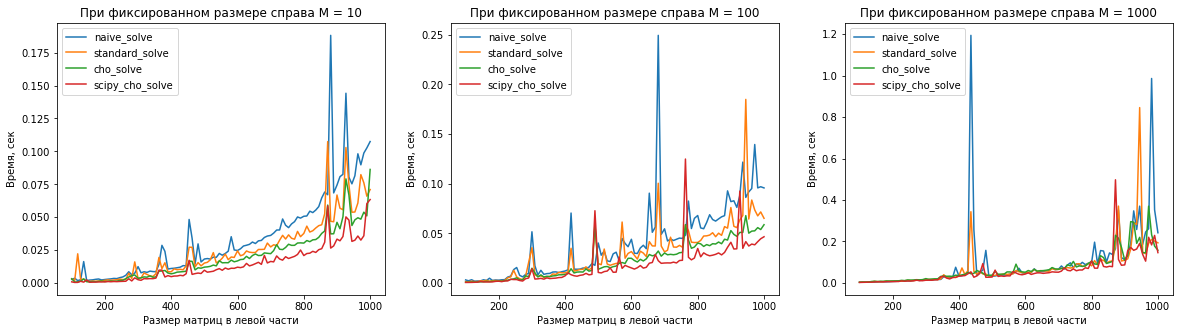

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))

M = [10, 100, 1000]

for i, m in enumerate(M):
    times_naive_solve,times_standard_solve,times_cho_solve,times_scipy_cho_solve = expirement_one(m)
    axes[i].plot(N, times_naive_solve, label = 'naive_solve')
    axes[i].plot(N, times_standard_solve, label = 'standard_solve')
    axes[i].plot(N, times_cho_solve, label = 'cho_solve')
    axes[i].plot(N, times_scipy_cho_solve, label = 'scipy_cho_solve')

    axes[i].set_xlabel("Размер матриц в левой части")
    axes[i].set_ylabel("Время, сек")
    axes[i].set_title("При фиксированном размере справа M = " + str(m))
    axes[i].legend()
plt.show()

In [23]:
M = np.linspace(10, 10000, 100, dtype=int)

def expirement_two(n):
    import timeit
    times_naive_solve = []
    times_standard_solve = []
    times_cho_solve = []
    times_scipy_cho_solve = []
    for m in M:
        tmp = np.random.rand(n, n)
        A = np.matmul(tmp, tmp.transpose())
        X_true = -5 + np.random.rand(n, m)*10
        B = np.matmul(A, X_true)

        st = timeit.default_timer()
        X = naive_solve(A,B)
        ft = timeit.default_timer()
        times_naive_solve.append(ft - st)

        st = timeit.default_timer()
        X = standard_solve(A,B)
        ft = timeit.default_timer()
        times_standard_solve.append(ft - st)

        st = timeit.default_timer()
        X = cho_solve(A,B)
        ft = timeit.default_timer()
        times_cho_solve.append(ft - st)

        st = timeit.default_timer()
        X = scipy_cho_solve(A,B)
        ft = timeit.default_timer()
        times_scipy_cho_solve.append(ft - st)
    return times_naive_solve,times_standard_solve,times_cho_solve,times_scipy_cho_solve

In [24]:
times_naive_solve,times_standard_solve,times_cho_solve,times_scipy_cho_solve = expirement_two(600)

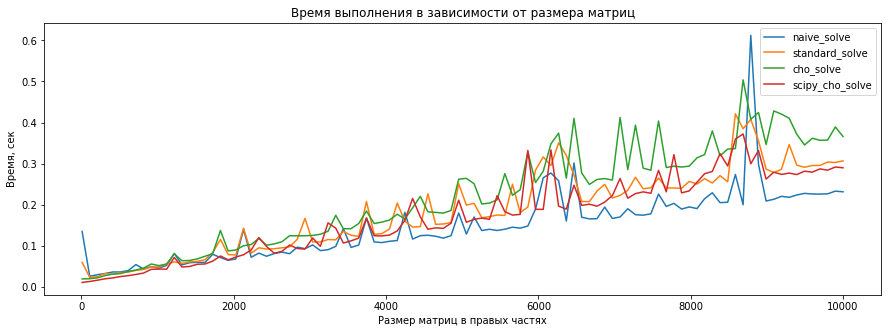

In [25]:
plt.figure(figsize=(15,5))
plt.plot(M, times_naive_solve, label = 'naive_solve')
plt.plot(M, times_standard_solve, label = 'standard_solve')
plt.plot(M, times_cho_solve, label = 'cho_solve')
plt.plot(M, times_scipy_cho_solve, label = 'scipy_cho_solve')

plt.title("Время выполнения в зависимости от размера матриц")
plt.xlabel("Размер матриц в правых частях")
plt.ylabel("Время, сек")
plt.legend()
plt.show()

**Как с ростом размера матриц в левой части, так и с ростом матриц в правой части на графиках видно, что время работы всех алгоритмов растёт. Лучше всех показывает себя метод scipy_cho_solve и хуже всех при изменении матриц в левых частях показал себя naive_solve, в случае изменений в правой части он немного улучшает позиции**

**В общем, можо сделать вывод, что если необходимо решить СЛАУ с положительно определенной матрицей, лучше использовать scipy_cho_solve.**


**Задание 2.2. Пример: вычисление логарифма плотности многомерного нормального распределения (3 балла)**

Случайная величина $\vec{x}\in\mathbb{R}^D$ имеет многомерное нормальное распределение, если её плотность может быть представлена как
$$
p(\vec{x}) = \mathcal{N}(\vec{x}|\vec{\mu},\Sigma) = \frac{1}{\sqrt{2\pi}^D\sqrt{\det\Sigma}}\exp\left(-\frac{1}{2}(\vec{x}-\vec{\mu})^T\Sigma^{-1}(\vec{x}-\vec{\mu})\right)
$$
Здесь $\vec{\mu}\in\mathbb{R}^D -$ вектор мат. ожидания $\vec{x}$, а $\Sigma\in\mathbb{R}^{D{\times}D} -$ матрица ковариации.

С помощью матричных разложений реализуйте алгоритм вычисления логарифма нормальной плотности для набора векторов $X = \{\vec{x}_1,\dots,\vec{x}_N\}$ для заданных $\vec{\mu}$ и $\Sigma$.

**Внимание**. Цель этого задания продемонстрировать вам возможности эффективного использования матричных вычислений, а не воспитать умение ускорять код на Питоне. Поэтому решения, в которых оптимизация достигнута с помощью Numba, Cython, С++-расширений или подобного им инструментария, будут оценены гораздо ниже, чем вы могли бы ожидать. Надеемся на понимание. 

**Так как матрица ковариации по определению положительно определенная, применим разложение Холецкого для матрицы $\Sigma$. Тогда, $\det\Sigma=\det L\det L^T = 2diagonal(L)$**

**И $(\vec{x}-\vec{\mu})^T\Sigma^{-1}(\vec{x}-\vec{\mu}) = (\vec{x}-\vec{\mu})^T\cdot({LL^T})^{-1}\cdot(\vec{x}-\vec{\mu}) = (L^{-1}(\vec{x}-\vec{\mu}))^T\cdot(L^{-1}(\vec{x}-\vec{\mu}))=Z^TZ$ **


In [23]:
def my_multivariate_normal_logpdf(X, m, S):
    '''
    Ввод
    -----
    X: набор точек, numpy array размера N x D;
    m: вектор средних значений, numpy array длины D;
    S: ковариационная матрицы, numpy array размера D x D.
    
    Вывод
    ------
    res: результат вычислений, numpy array длины N.
    '''
    D = len(X)
    L = sla.cholesky(S, lower=True)
    T = -D*0.5 * np.log(2 * np.pi) - np.log(np.prod(np.diag(L)))
    Z = np.matmul(sla.inv(L),(X - m))
    return T - 0.5*np.matmul(Z.T,Z)

Сгенерируйте выборку из нормального распределения со случайными параметрами для небольшого $D$ с помощью функции `scipy.stats.multivariate_normal.rvs` и сравните на этой выборке результат работы вашего алгоритма с результатом стандартной функции `scipy.stats.multivariate_normal.logpdf`

In [24]:
import scipy.stats as stat
D = 4

mean = -5 + np.random.rand(D)*10
tmp = -5 + np.random.rand(D, D)*10
cov = np.matmul(tmp, tmp.T)
X = stat.multivariate_normal(mean=mean, cov=cov).rvs(size=1)

y = stat.multivariate_normal.logpdf(X, mean=mean, cov=cov)
print (y)
y_my = my_multivariate_normal_logpdf(X, mean, cov)
print(y_my)

-8.073719275698693
-8.0737192756987


**Ура, мы сделали правильно! Сравнимся с scipy.stats.multivariate_normal.logpdf**

Замерьте время работы вашего алгоритма и функции `scipy.stats.multivariate_normal.logpdf` для различных значений $D$. Постарайтесь добиться, чтобы ваш алгоритм выигрывал по скорости у стандартной функции.

In [25]:
D = np.linspace(50, 200, 20, dtype=int)
errors = []

def expirement_time():
    import timeit
    times_multivariate_normal = []
    times_my_multivariate_normal_logpdf = []
    
    for d in D:
        mean = -5 + np.random.rand(d)*10
        tmp = -5 + np.random.rand(d, d)*10
        cov = np.matmul(tmp, tmp.T)
        X = stat.multivariate_normal(mean=mean, cov=cov).rvs(size=1)

        st = timeit.default_timer()
        Y_true = stat.multivariate_normal.logpdf(X, mean=mean, cov=cov)
        ft = timeit.default_timer()
        times_multivariate_normal.append(ft - st)
        
        st = timeit.default_timer()
        Y_my = my_multivariate_normal_logpdf(X, mean, cov)
        ft = timeit.default_timer()
        times_my_multivariate_normal_logpdf.append(ft - st)
        
        errors.append(abs(Y_true - Y_my)/abs(Y_true))

    return times_multivariate_normal,times_my_multivariate_normal_logpdf

[2.9885350294096934e-15, 3.2917249020416364e-15, 0.0, 9.470127229926045e-15, 5.001441790946817e-16, 6.896416014132193e-15, 8.628801553110237e-15, 2.3770323567884706e-15, 7.331298680826221e-15, 6.4531229999768e-16, 2.229139257518092e-15, 1.1283427943312137e-14, 1.961171441802305e-15, 5.277310523816427e-15, 1.705955284685107e-15, 7.448563649714836e-16, 1.0540906884126627e-14, 9.368984110618018e-16, 5.153936450099347e-16, 3.683780419144589e-14]


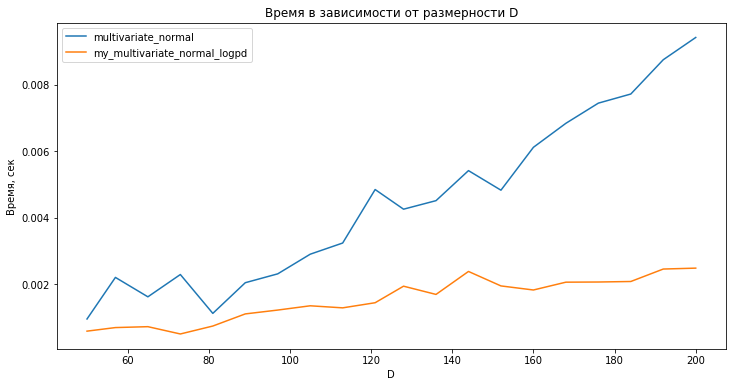

In [26]:
times_multivariate_normal,times_my_multivariate_normal_logpd = expirement_time()

print(errors)

plt.figure(figsize=(12,6))
plt.plot(D, times_multivariate_normal, label = 'multivariate_normal')
plt.plot(D, times_my_multivariate_normal_logpd, label = 'my_multivariate_normal_logpd')

plt.title("Время в зависимости от размерности D")
plt.xlabel("D")
plt.ylabel("Время, сек")
plt.legend()

В задаче будут оцениваться:
- удалось ли вам обогнать библиотечную функцию;
- использованы ли вы матричные разложения (или просто обратили матрицу:))
- наличие дополнительных оптимизаций

**Я вывел массив относительных ошибок, с каждым разлиным D. Видно, что результаты схожи в точности до знака вещественного представления. Так же видно, что моя реализация очень сильно превосходит по времени с ростом D.**

## Часть 3. Разреженные матрицы

Вот здесь http://docs.scipy.org/doc/scipy/reference/sparse.html можно посмотреть, как различные форматы разреженных матриц реализованы в библиотеке `scipy`.

Вот здесь https://www.cise.ufl.edu/research/sparse/matrices/index.html выложено много разреженных матриц из разнообразных приложений. Что особенно приятно, сайт предоставляет удобный клиент для скачивания, в котором доступен предпросмотр и данные о том, являются ли матрицы симметричными или положительно определёнными.

**Задание 3.1 (0,5 балла)** Когда мы анализировали время преобразований между различными форматами, вы могли заметить, что преобразование из формата `LIL` в формат `CSR` занимает гораздо больше времени, чем преобразования между форматами `COO`, `CSR` и `CSC`. Почему так происходит?

**В случае форматов COO, CSR и CSC массив значений не меняется, изменяются только два других (например, массив индексов столбцов и массив смещений индексов строк). А в случае LIL приходится обновлять матрицу с нуля.**

**Задание 3.2 (1 балл)** Торговая сеть предоставила вам данные о покупках своих клиентов, представляющие собою 
таблицу со столбцами 
* Номер записи
* *InvoiceNo* - номер чека
* *StockCode* - код товара
* *Description* - название товара

Чтобы понять, какие товары покупают вместе, вы решили построить (разреженную) матрицу, строки и столбцы которой соответствуют различным товарам, а в клетке с "номером" $(g_1, g_2)$ стоит число $c(g_1 \& g_2)$ --- количество чеков, содержащих оба товара. 

Ниже приведён код, который вам нужно дополнить, дописав функцию ``CreateMatrix``, создающая из структуры pandas.DataFrame разреженную матрицу. Ваша реализация должна удовлетворять следующим свойствам:
* матрица должна создаваться эффективно и по возможности с минимальным числом циклов;
* итоговая матрица должна позволять быстро отвечать на следующие вопросы:
  - сколько всего было куплено товаров данного типа?
  - какие пары товаров покупались вместе чаще всего?
  - какие товары чаще всего покупались вместе с данным товаром?

Пожалуйста, объясните, почему вы выбрали именно ту, а не иную архитектуру.

**Необходим быстрый доступ к строкам. Фоматы COO, DOC, CSC работают достаточно медленно с доступом к строкам. Формат LIL слишком много памяти ест и преобразования с LIL к другим форматам происходит очень медленно. Поэтому для решения этой задачи был выбран формат CSR.**

Загрузим данные:

In [50]:
import pandas as pd
receipts = pd.read_csv('Online Retail Short.csv', sep=';')

Распечатаем первые несколько строк, чтобы осознать структуру данных:

In [51]:
receipts.head()

,Unnamed: 0,InvoiceNo,StockCode,Description
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,1,536365,71053,WHITE METAL LANTERN
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.


А теперь та самая функция. Вам могут пригодиться следующие конструкции:

* ``for name, group in data.groupby('InvoiceNo')`` --- цикл, в котором ``name`` будут различными значениями ``InvoiceNo``, а ``group`` --- кусками нашего ``DataFrame`` с заданным значением ``InvoiceNo``.
* ``for g1, g2 in itertools.combinations(list(group['StockCode']), 2)`` --- цикл, пробегающий пары различных элементов (сочетания по 2) из списка товаров из заданной группы.


In [75]:
import scipy.sparse as sps
import itertools
import numpy as np

stoock_id = {idx: elem for idx,elem in enumerate(receipts['StockCode'].unique())}
id_stoock = {elem: idx for idx,elem in enumerate(receipts['StockCode'].unique())}

def CreateMatrix(data):
    '''
    Ввод
    -----
    receipts: структура pandas.DataFrame
    
    Вывод
    ------
    res: разреженная матрица
    '''
    nrows = len(id_stoock)
    matrix = np.zeros((nrows, nrows))
    for name, group in data.groupby('InvoiceNo'):
        group = group['StockCode'].unique()
        for g1, g2 in itertools.combinations(group, 2):
            matrix[id_stoock[g1], id_stoock[g2]] += 1
            matrix[id_stoock[g2], id_stoock[g1]] += 1
            
    matrix = sps.csc_matrix(matrix) 
    return matrix

А теперь с помощью созданной вами матрицы ответьте на несколько вопросов:

1) Какая пара товаров была куплена вместе наибольшее число раз? Пожалуйста, в качестве ответа укажите не id, а названия из столбца ``Descriptions``.

2) Что чаще всего покупали вместе с ``KNITTED UNION FLAG HOT WATER BOTTLE``?

В вашем ноутбуке должно быть продемонстрировано, как вы это находите с помощью матрицы!

In [76]:
csr = CreateMatrix(receipts)

###### 1) Какая пара товаров была куплена вместе наибольшее число раз? 

In [77]:
i, j = np.unravel_index(csr.argmax(), csr.shape)

In [78]:
max_buy_1 = receipts['Description'][receipts['StockCode']==stoock_id[i]].iloc[0]
max_buy_2 = receipts['Description'][receipts['StockCode']==stoock_id[j]].iloc[0]
print(max_buy_1, max_buy_2)

ROSES REGENCY TEACUP AND SAUCER  GREEN REGENCY TEACUP AND SAUCER


**Пара ``ROSES REGENCY TEACUP AND SAUCER`` и ``GREEN REGENCY TEACUP AND SAUCER`` была куплена больше всего раз**

###### 2) Что чаще всего покупали вместе с ``KNITTED UNION FLAG HOT WATER BOTTLE``?

In [87]:
stoock = receipts['StockCode'][receipts['Description']=='KNITTED UNION FLAG HOT WATER BOTTLE'].iloc[0]

In [88]:
argmax = csr[id_stoock[stoock]].argmax()
print(receipts['Description'][receipts['StockCode']==stoock_id[argmax]].iloc[0])

CHOCOLATE HOT WATER BOTTLE


** Чаще всего с ``KNITTED UNION FLAG HOT WATER BOTTLE`` покупали ``CHOCOLATE HOT WATER BOTTLE``**